# Feature Set Analysis

In [76]:
import init
import common.constants as cn
import common_python.constants as ccn
from common.trinary_data import TrinaryData
from common.data_provider import DataProvider
from common.data_provider import DataProvider
from common_python.plots import util_plots
from plots import util_plots as xutil_plots
from common_python.classifier import feature_analyzer
from common_python.classifier import feature_set_collection
from common_python.util import util
from common import transform_data
from common_python.classifier.feature_set import FeatureSet

import datetime
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn
from sklearn import svm

%matplotlib inline

In [35]:
# These are the "long" data that have individual replications, not averages. And, only using TFs.
PROVIDER = DataProvider()
PROVIDER.do()
TRINARY = TrinaryData(is_averaged=False, is_dropT1=False, is_regulator=True)  # Trinary data
DF_X = TRINARY.df_X
SER_Y = TRINARY.ser_y
STATES = SER_Y.unique()
REGULATORS = DF_X.columns.tolist()
DATA_PATH = cn.PROJECT_DIR
for directory in ["data", "feature_analyzer"]:
    DATA_PATH = os.path.join(DATA_PATH, directory)
DATA_PATH_PAT = os.path.join(DATA_PATH, "%d") 
ANALYZER_DCT = feature_analyzer.deserialize({s: DATA_PATH_PAT % s for s in STATES})
ANALYZERS = ANALYZER_DCT.values()
COLLECTION_DCT = {s: feature_set_collection.FeatureSetCollection.deserialize(DATA_PATH_PAT % s) for s in STATES}
_ = [c.ser_comb for c in COLLECTION_DCT.values()]

In [39]:
PROVIDER.df_go_terms.head()

,GENE_ID,GO_Term
0,P9WKY5,host cell nucleus
1,Rv0001,DNA replication initiation---dephosphorylation...
2,Rv0002,extracellular region---cell wall
3,Rv0003,double-strand break repair---cytosol---plasma ...
4,Rv0005,DNA topological change---growth---magnesium io...


In [23]:
DF_AM = transform_data.trinaryReadsDF(
    csv_file="AM_MDM_Mtb_transcripts_DEseq.csv", is_time_columns=False).T
DF_AW = transform_data.trinaryReadsDF(
"AW_plus_v_AW_neg_Mtb_transcripts_DEseq.csv", is_time_columns=False).T

**Warning: Data doesn't have gene AS1726
**Warning: Data doesn't have gene AS1890
**Warning: Data doesn't have gene ASdes
**Warning: Data doesn't have gene ASpks
**Warning: Data doesn't have gene MT0009
**Warning: Data doesn't have gene MT0012
**Warning: Data doesn't have gene MT0025
**Warning: Data doesn't have gene MT0031
**Warning: Data doesn't have gene MT0032
**Warning: Data doesn't have gene MT0036
**Warning: Data doesn't have gene MT0066.2
**Warning: Data doesn't have gene MT0069
**Warning: Data doesn't have gene MT0099.1
**Warning: Data doesn't have gene MT0116.1
**Warning: Data doesn't have gene MT0122
**Warning: Data doesn't have gene MT0124
**Warning: Data doesn't have gene MT0130
**Warning: Data doesn't have gene MT0159
**Warning: Data doesn't have gene MT0177
**Warning: Data doesn't have gene MT0204.1
**Warning: Data doesn't have gene MT0270
**Warning: Data doesn't have gene MT0270.2
**Warning: Data doesn't have gene MT0291.1
**Warning: Data doesn't have gene MT0291.2
**Wa

**Warning: Data doesn't have gene Rv0397A
**Warning: Data doesn't have gene Rv0456B
**Warning: Data doesn't have gene Rv0530A
**Warning: Data doesn't have gene Rv0616A
**Warning: Data doesn't have gene Rv0691A
**Warning: Data doesn't have gene Rv0959A
**Warning: Data doesn't have gene Rv1366A
**Warning: Data doesn't have gene Rv1962A
**Warning: Data doesn't have gene Rv1982A
**Warning: Data doesn't have gene Rv1991A
**Warning: Data doesn't have gene Rv2063A
**Warning: Data doesn't have gene Rv2142A
**Warning: Data doesn't have gene Rv2231A
**Warning: Data doesn't have gene Rv2231B
**Warning: Data doesn't have gene Rv2237A
**Warning: Data doesn't have gene Rv2274A
**Warning: Data doesn't have gene Rv2395A
**Warning: Data doesn't have gene Rv2395B
**Warning: Data doesn't have gene Rv2427A
**Warning: Data doesn't have gene Rv2468A
**Warning: Data doesn't have gene Rv2548A
**Warning: Data doesn't have gene Rv2801A
**Warning: Data doesn't have gene Rv2828A
**Warning: Data doesn't have gene 

**Warning: Data doesn't have gene Rv0397A
**Warning: Data doesn't have gene Rv0456B
**Warning: Data doesn't have gene Rv0530A
**Warning: Data doesn't have gene Rv0616A
**Warning: Data doesn't have gene Rv0691A
**Warning: Data doesn't have gene Rv0959A
**Warning: Data doesn't have gene Rv1366A
**Warning: Data doesn't have gene Rv1962A
**Warning: Data doesn't have gene Rv1982A
**Warning: Data doesn't have gene Rv1991A
**Warning: Data doesn't have gene Rv2063A
**Warning: Data doesn't have gene Rv2142A
**Warning: Data doesn't have gene Rv2231A
**Warning: Data doesn't have gene Rv2231B
**Warning: Data doesn't have gene Rv2237A
**Warning: Data doesn't have gene Rv2274A
**Warning: Data doesn't have gene Rv2395A
**Warning: Data doesn't have gene Rv2395B
**Warning: Data doesn't have gene Rv2427A
**Warning: Data doesn't have gene Rv2468A
**Warning: Data doesn't have gene Rv2548A
**Warning: Data doesn't have gene Rv2801A
**Warning: Data doesn't have gene Rv2828A
**Warning: Data doesn't have gene 

In [14]:
#  alveolar macrophages
path = os.path.join(cn.DATA_DIR, "samples")
path = os.path.join(path, "AM_MDM_Mtb_transcripts_DEseq.csv")
DF_AM = pd.read_csv(path)
DF_AM = DF_AM.set_index(cn.GENE_ID)
DF_AM = DF_AM.T
df_AM.head()

GENE_ID,AS1726,AS1890,ASdes,ASpks,MT0009,MT0012,MT0025,MT0031,MT0032,MT0036,...,Rvnt36,Rvnt37,Rvnt38,Rvnt39,Rvnt40,Rvnt41,Rvnt42,Rvnt43,Rvnt44,Rvnt45
AM_D20_1,5.534958,6.567797,1042.584746,0.648835,3.204449,133.924788,6.951801,279.687500,254.091631,0.993114,...,17.756886,1093.710275,15.108581,136.308263,24.126059,6.011653,188.916843,7.256356,22.881356,8.673199
AM_D20_3,5.415784,28.641419,164.804025,1.099047,0.000000,24.457097,0.000000,669.107521,11.970339,0.000000,...,12.460275,51.814089,7.203390,9.176377,11.242055,9.706038,45.312500,0.873941,1.244703,0.000000
AM_D20_4,0.000000,1.059322,229.992055,0.000000,0.000000,46.901483,0.000000,14.698093,346.729343,0.000000,...,4.263771,0.370763,1.602225,0.370763,0.370763,0.635593,0.000000,0.000000,0.000000,0.000000
AM_D20_5,6.038136,3.707627,340.029131,4.766949,0.000000,76.403602,206.673729,70.100636,0.000000,0.000000,...,11.480403,24.377648,1.853814,0.132415,105.230402,6.038136,16.181144,0.000000,0.000000,1.959746
MDM_D20_1,0.992589,1.191106,8.178931,2.038115,0.000000,5.651138,0.000000,11.553732,6.034939,1.998412,...,0.039704,13.380095,0.317628,1.310217,4.645315,0.000000,11.434621,3.851244,3.096877,1.270513


# Alternative Feature Sets

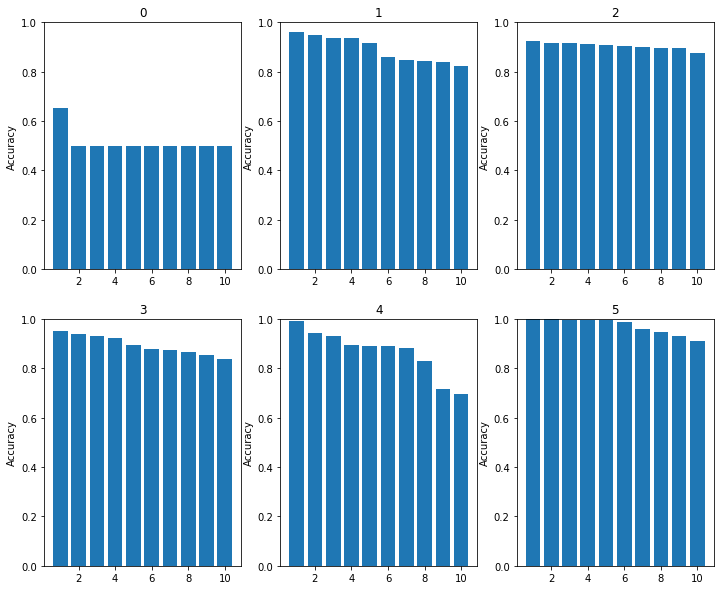

In [72]:
nrow = 2
ncol = 3
xv = range(1, 11)
fig, axes = plt.subplots(nrow, ncol, figsize=(12, 10))
for state in STATES:
    row = int(state/ncol)
    col = state % ncol
    collection = COLLECTION_DCT[state]
    ax = axes[row, col]
    values = collection.ser_comb.to_list()
    ax.bar(xv, values[:len(xv)])
    ax.set_ylabel("Accuracy")
    ax.set_ylim([0, 1])
    ax.set_title("%d" % state)
    
    

In [73]:
COLLECTION_DCT[1].ser_comb.head()

Rv3095+Rv3246c                            0.958333
Rv2009+Rv3830c                            0.950000
Rv0054+Rv3066+Rv3133c                     0.936667
Rv0158+Rv0653c+Rv1176c+Rv2745c+Rv3082c    0.935000
Rv1460                                    0.915000
Name: 0, dtype: float64

In [80]:
fset = FeatureSet("Rv3095+Rv3246c", analyzer=COLLECTION_DCT[1]._analyzer)
df = fset.profileTrinary()
del df["feature_set"]
df

,predicted,count,frac,siglvl_pos,siglvl_neg
value,,,,,
"(-1, -1)",0,2.0,0.00,1.000000,0.000000
"(-1, 0)",0,22.0,0.00,1.000000,0.000000
"(-1, 1)",0,11.0,0.00,1.000000,0.000000
"(0, -1)",0,0.0,NaN,NaN,NaN
"(0, 0)",0,20.0,0.05,0.999999,0.000020
"(0, 1)",1,20.0,0.85,0.001288,0.999799
"(1, -1)",0,0.0,NaN,NaN,NaN
"(1, 0)",1,0.0,NaN,NaN,NaN
"(1, 1)",1,0.0,NaN,NaN,NaN


## Profile Instances

In [3]:
def plotProfile(state, count=3):
    collection = COLLECTION_DCT[state]
    collection.plotProfileInstance(collection.ser_comb.index.tolist()[0:count], figsize=(16, 10))

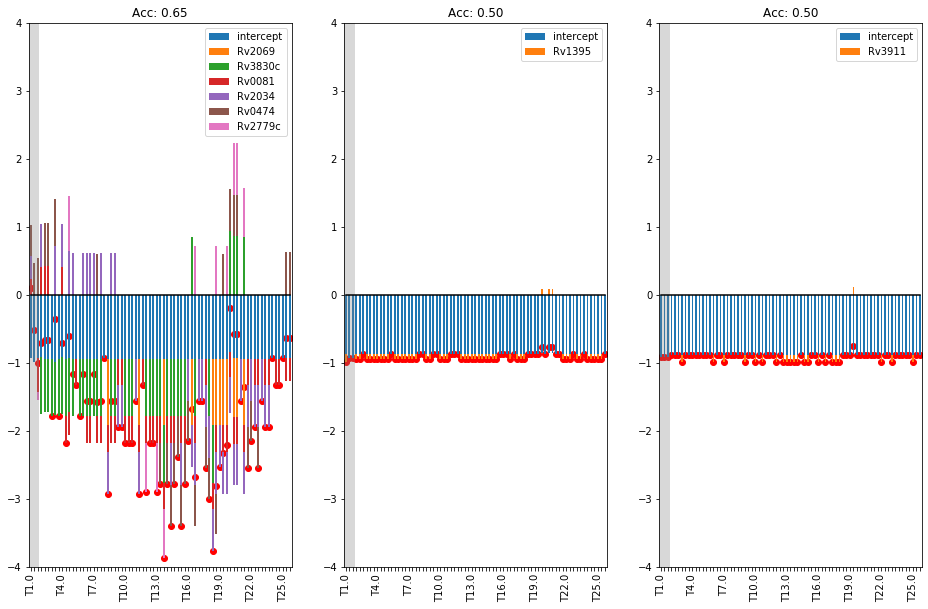

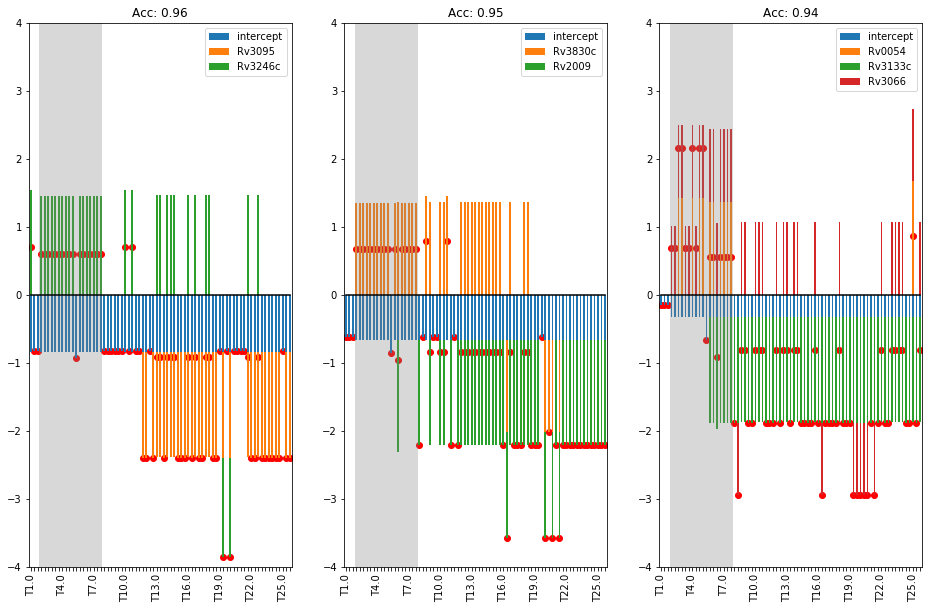

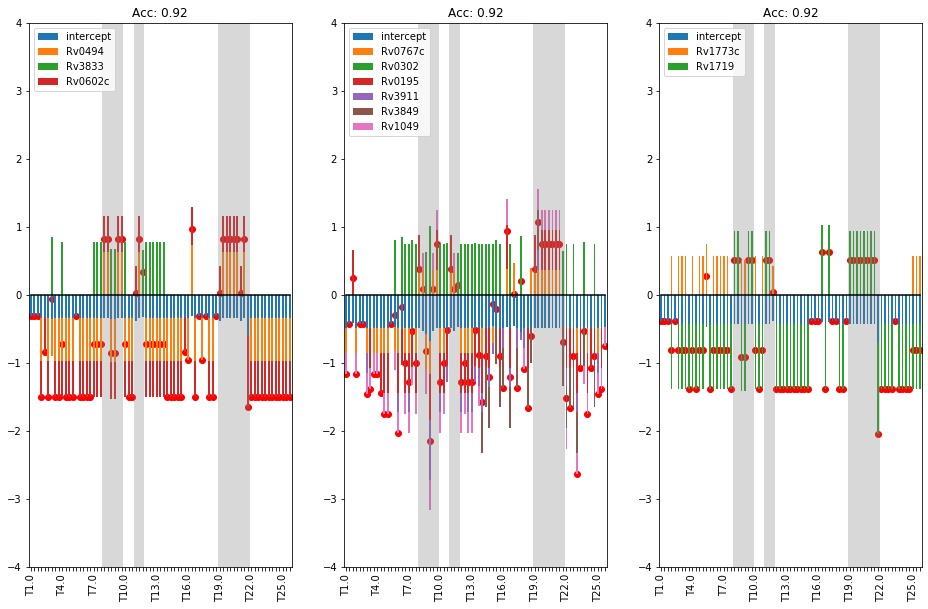

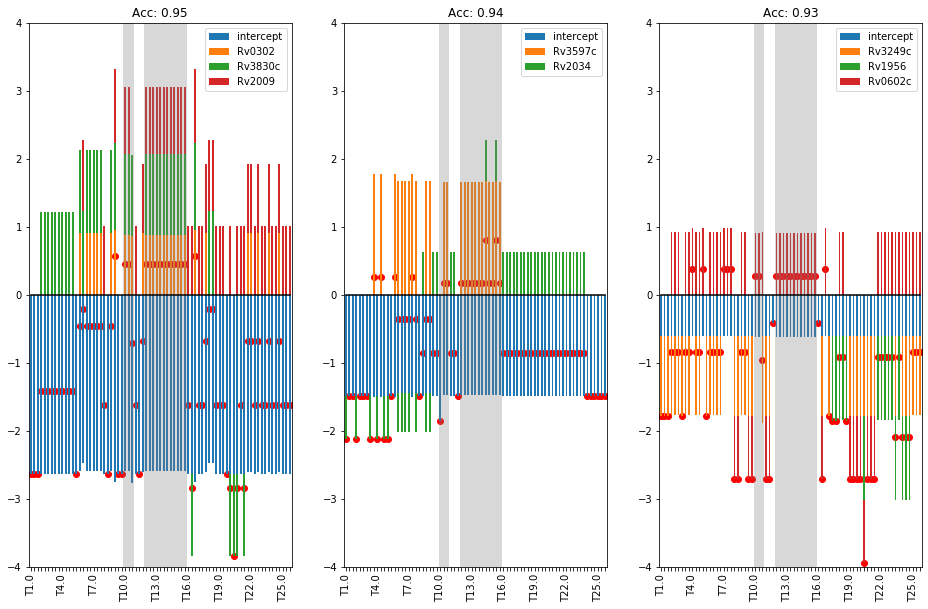

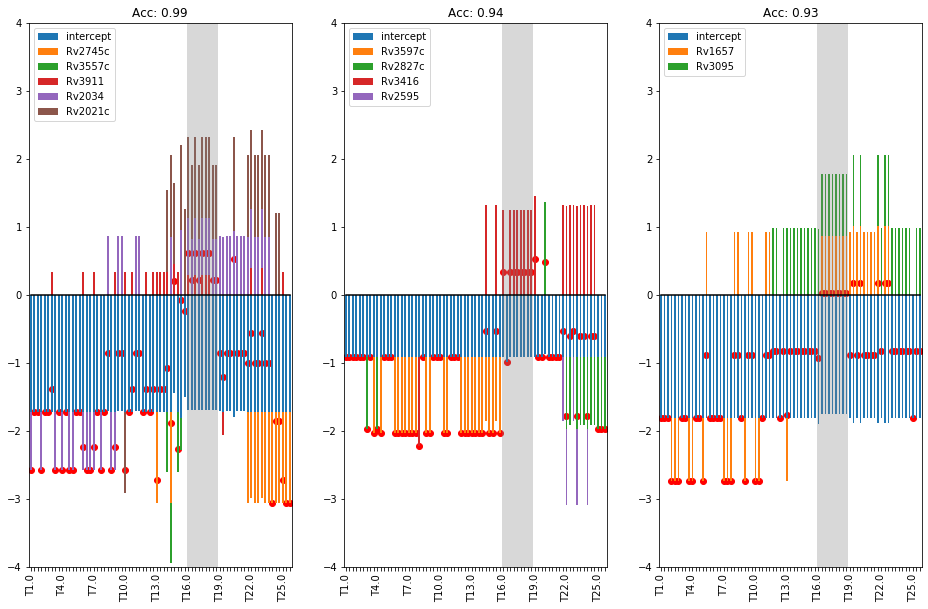

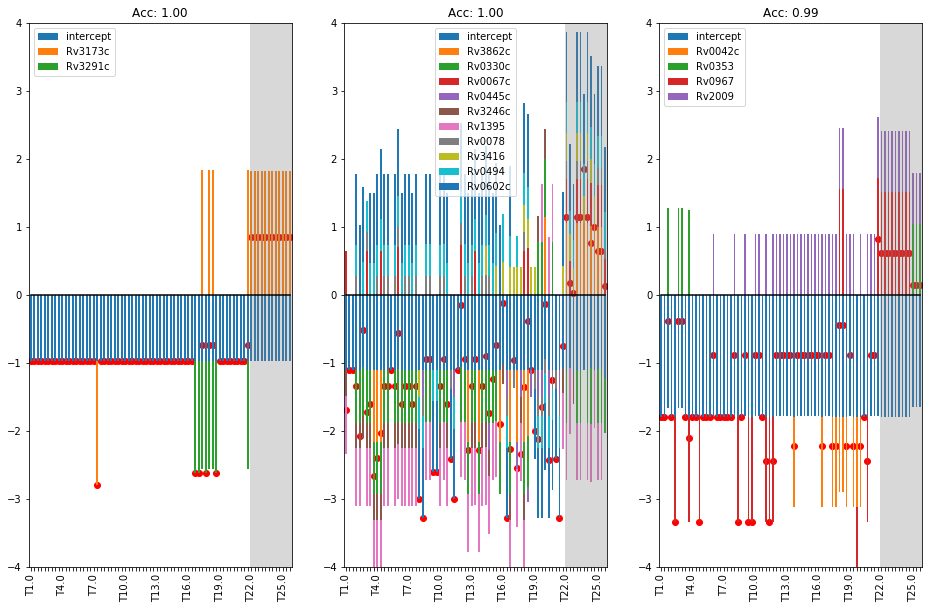

In [4]:
for state in STATES:
    plotProfile(state)

## Instance Evaluation

In [5]:
 def fullProfile(ser_X, title=""):
        num_row = 2 
        num_col = 3 
        fig, axes = plt.subplots(num_row, num_col,
            figsize=(16, 10))
        for idx, state in enumerate(STATES):
            row = int(idx/num_col)
            col = idx % num_col
            collection = COLLECTION_DCT[state]
            if row == 0:
                label_xoffset = -0.1
            else:
                label_xoffset = 0.1 
            collection.plotEvaluate(ser_X, 
                ax=axes[row, col], is_plot=False,
                title = "State %d" % idx,
                label_xoffset=label_xoffset)
        fig.suptitle(title, fontsize=16)
        plt.show()

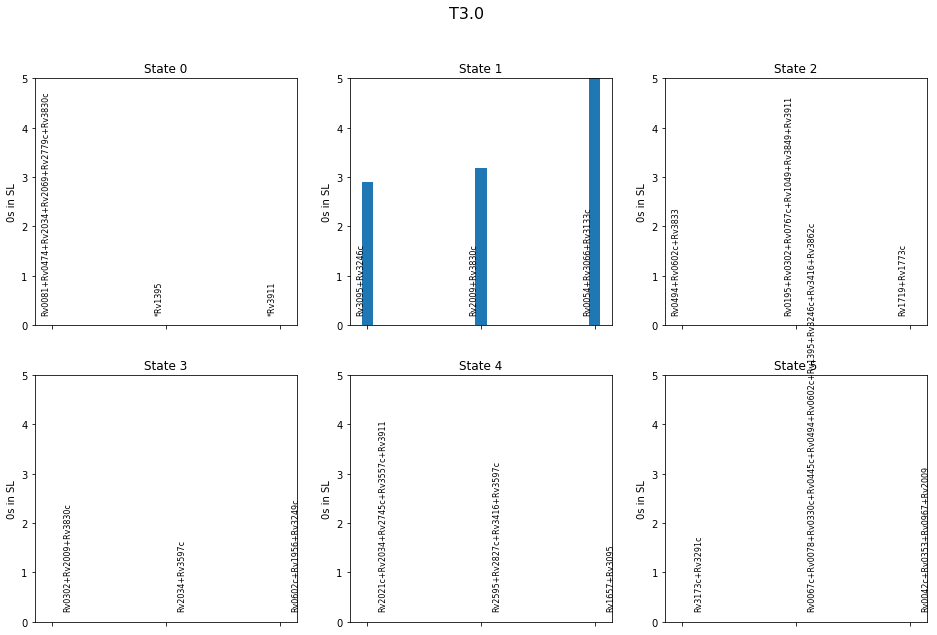

In [6]:
instance = "T3.0"
ser_X = DF_X.loc[instance]
fullProfile(ser_X, title=instance)

In [31]:
DF_AW.head()

GENE_ID,Rv0001,Rv0005,Rv0006,Rv0009,Rv0010c,Rv0011c,Rv0013,Rv0014c,Rv0016c,Rv0020c,...,Rvnt36,Rvnt37,Rvnt38,Rvnt39,Rvnt40,Rvnt41,Rvnt42,Rvnt43,Rvnt44,Rvnt45
AW_plus_1,0,0,0,0,-1,0,-1,0,0,0,...,0,0,-1,0,-1,0,-1,0,0,-1
AW_neg_1,1,1,0,0,-1,1,-1,0,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
AW_plus_3,0,0,0,0,-1,1,0,0,0,0,...,0,0,-1,0,-1,-1,-1,-1,-1,-1
AW_neg_3,1,0,0,0,-1,1,0,0,0,0,...,0,-1,-1,-1,-1,-1,-1,-1,-1,-1
AW_plus_4,0,0,0,0,-1,1,0,0,0,0,...,0,0,-1,-1,-1,-1,-1,-1,-1,1


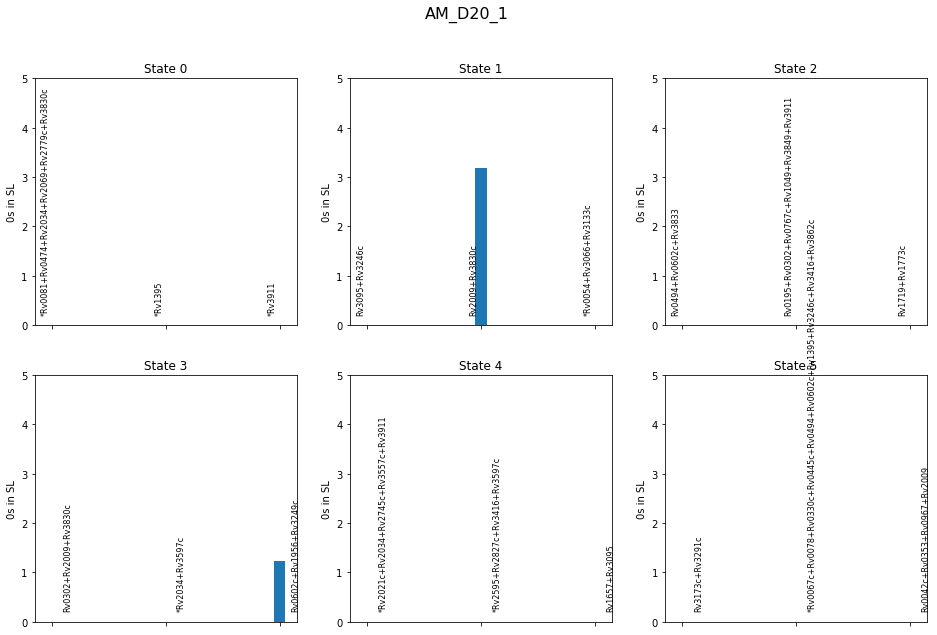

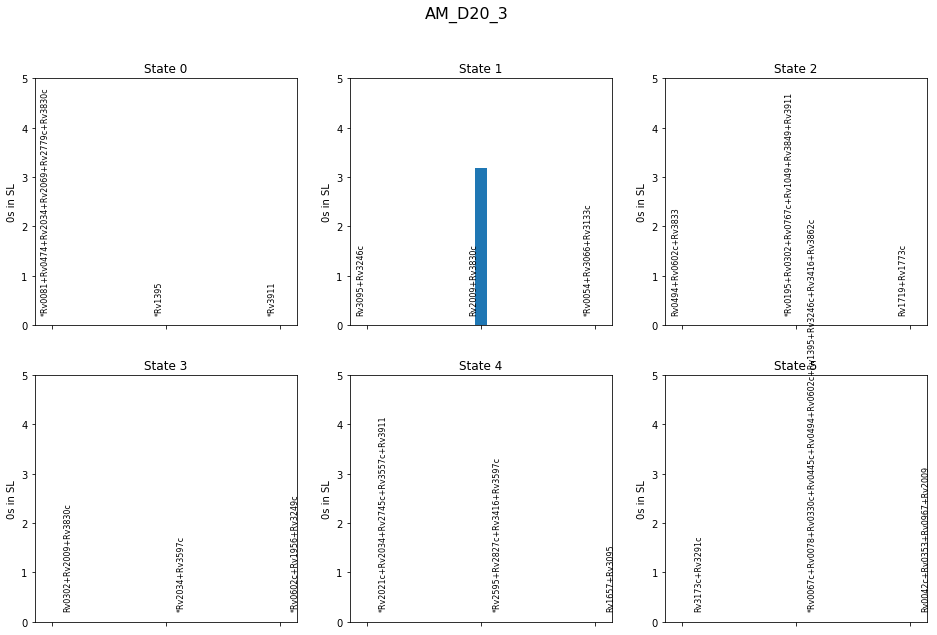

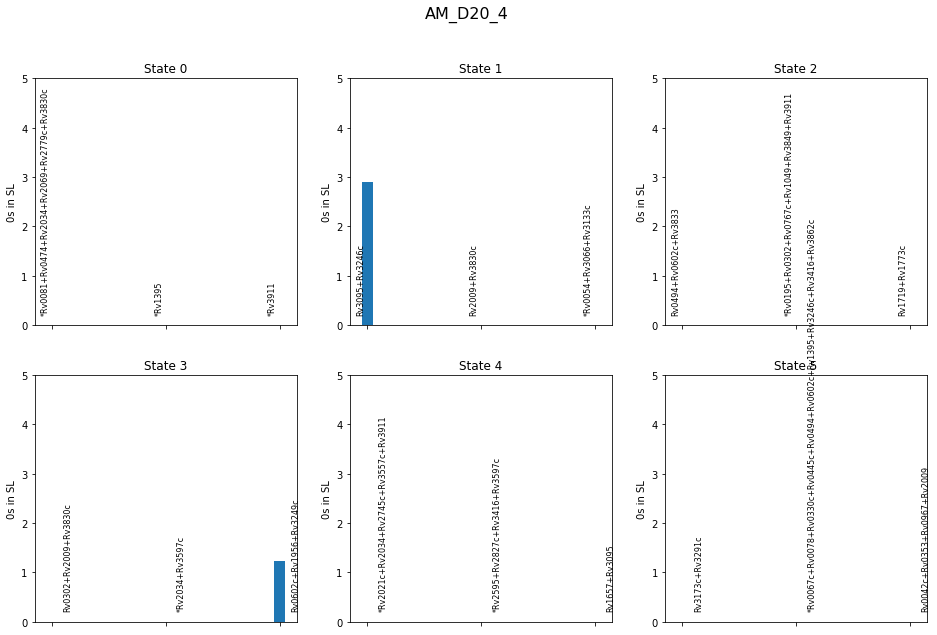

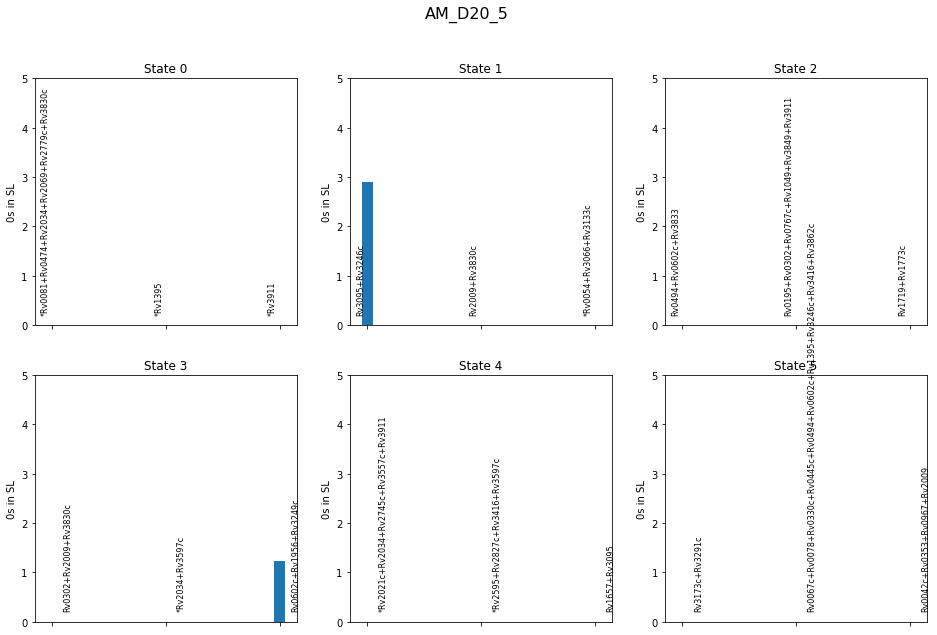

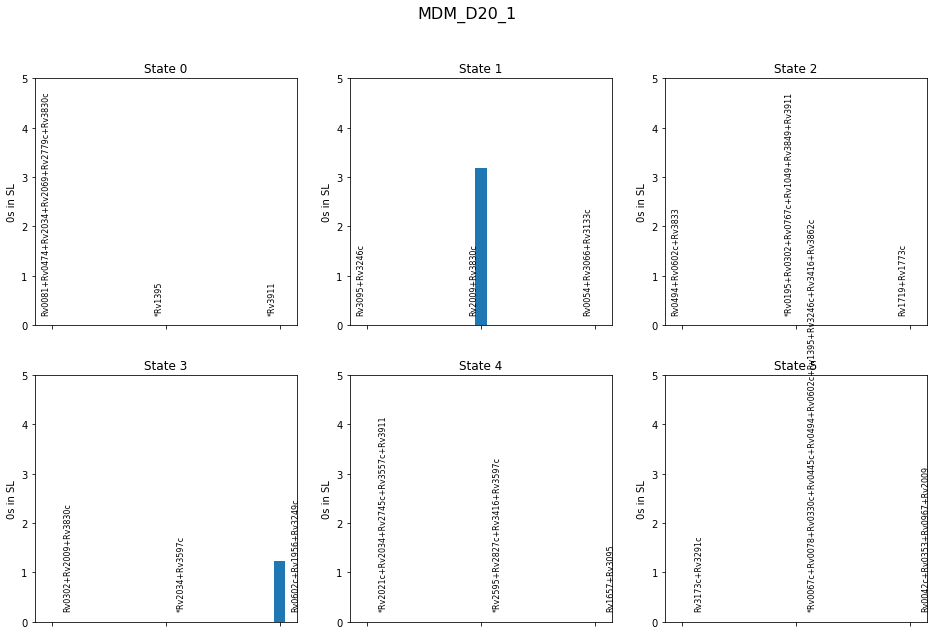

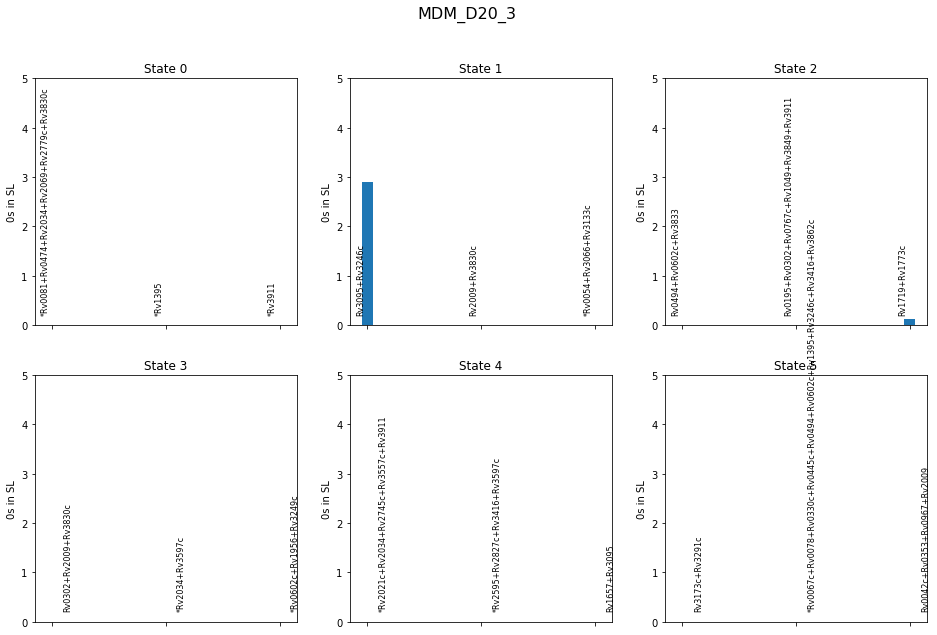

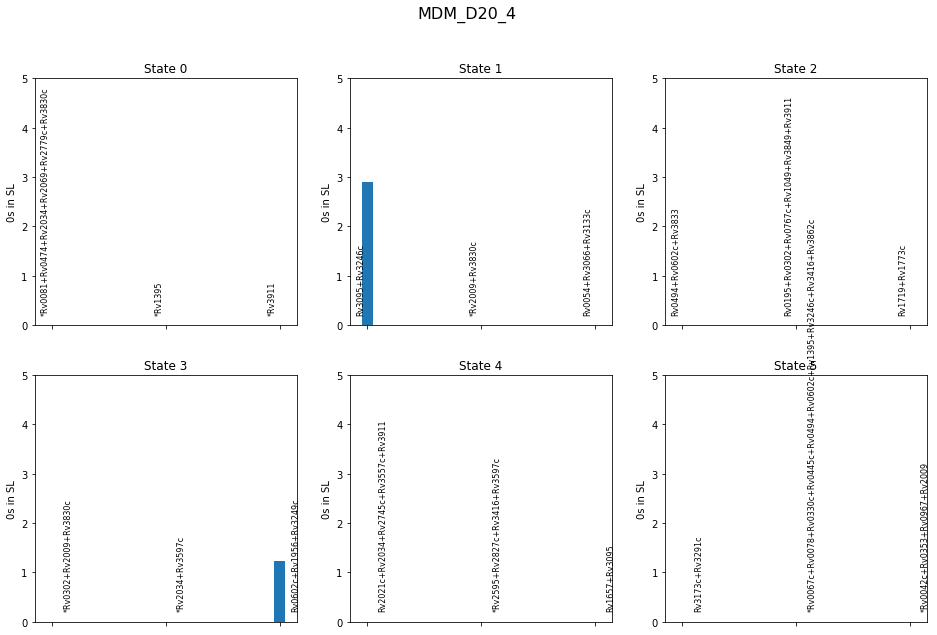

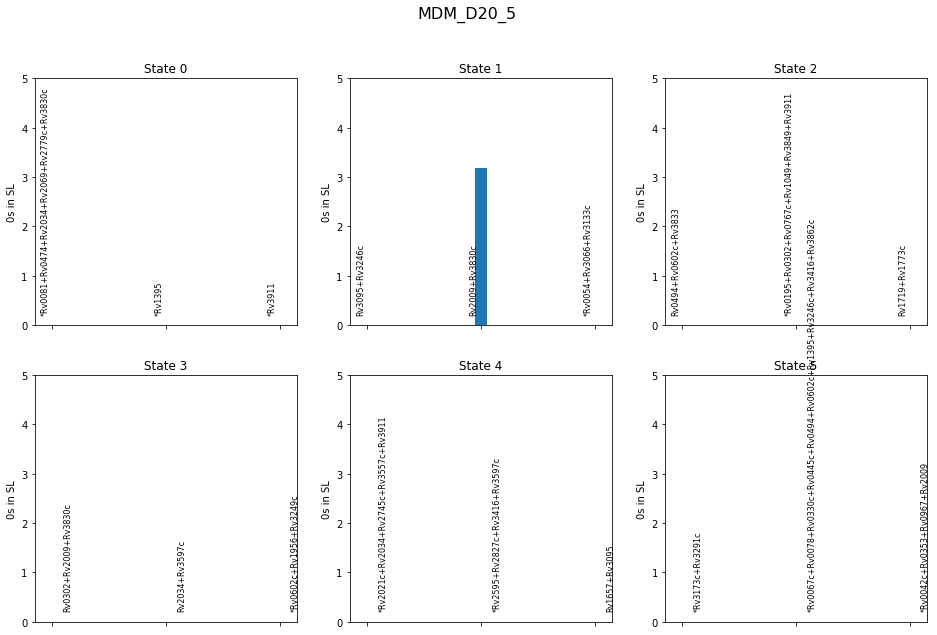

In [29]:
for instance in DF_AM.index:
    ser_X = DF_AM.loc[instance]
    fullProfile(ser_X, title=instance)

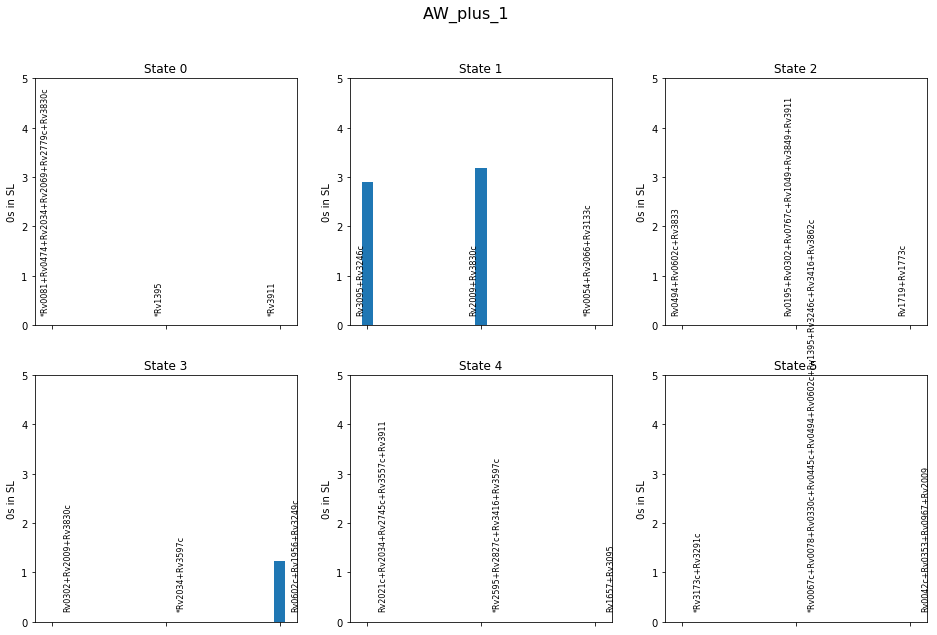

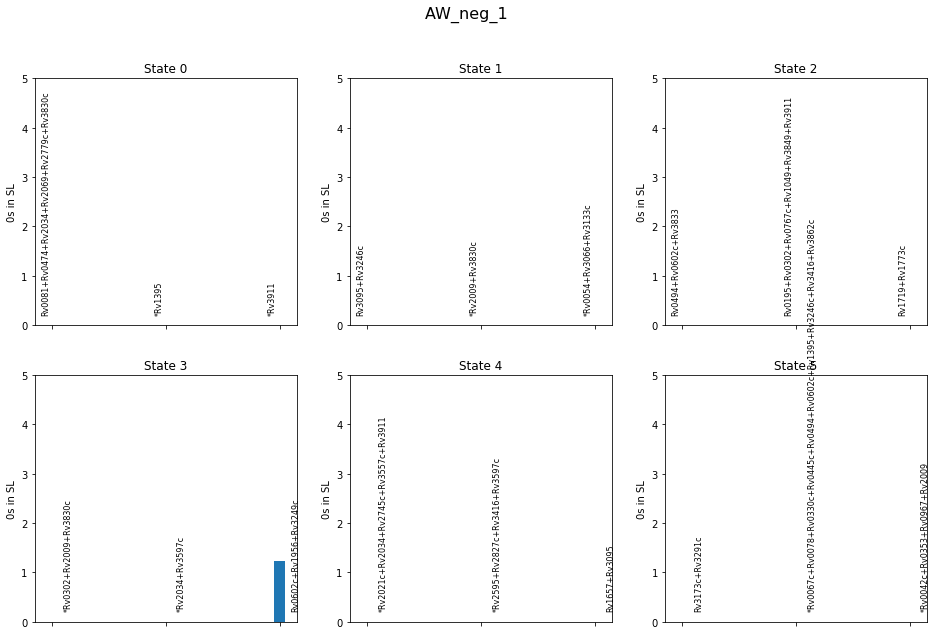

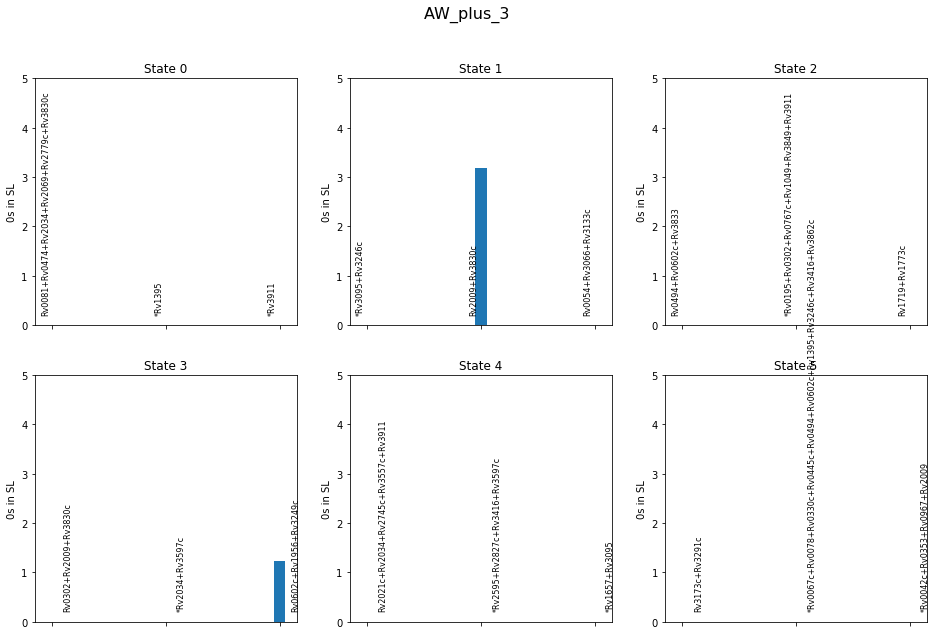

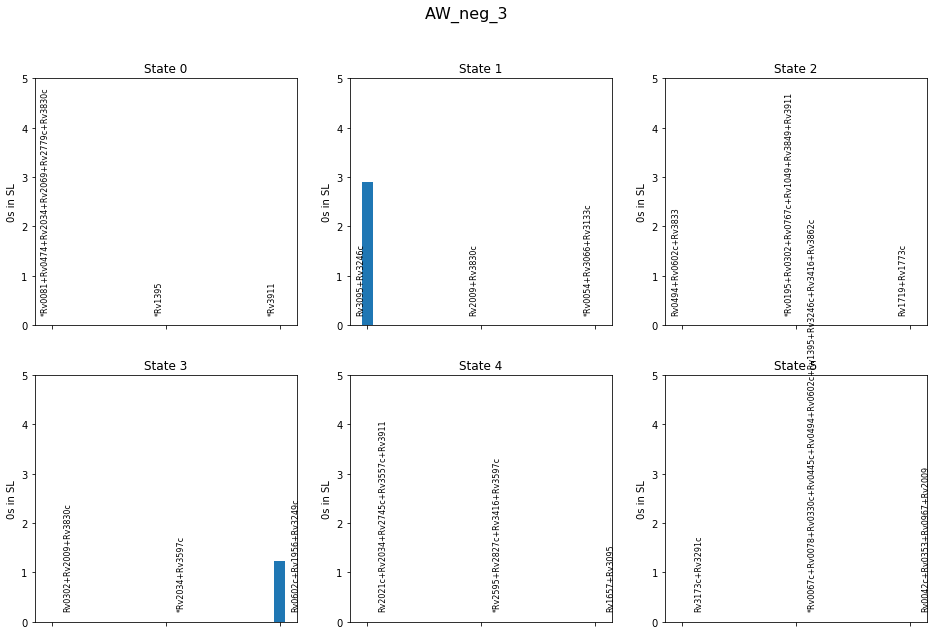

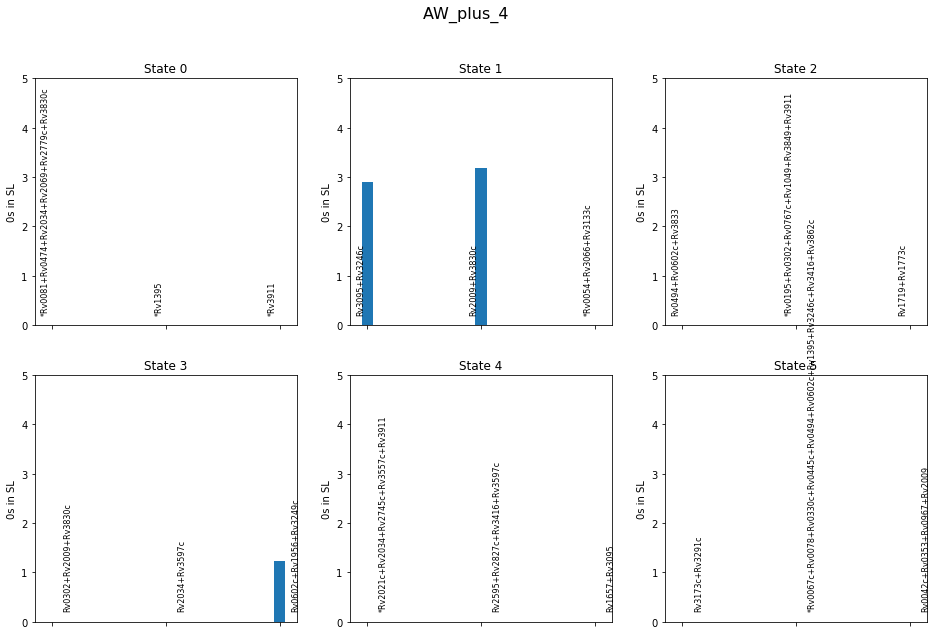

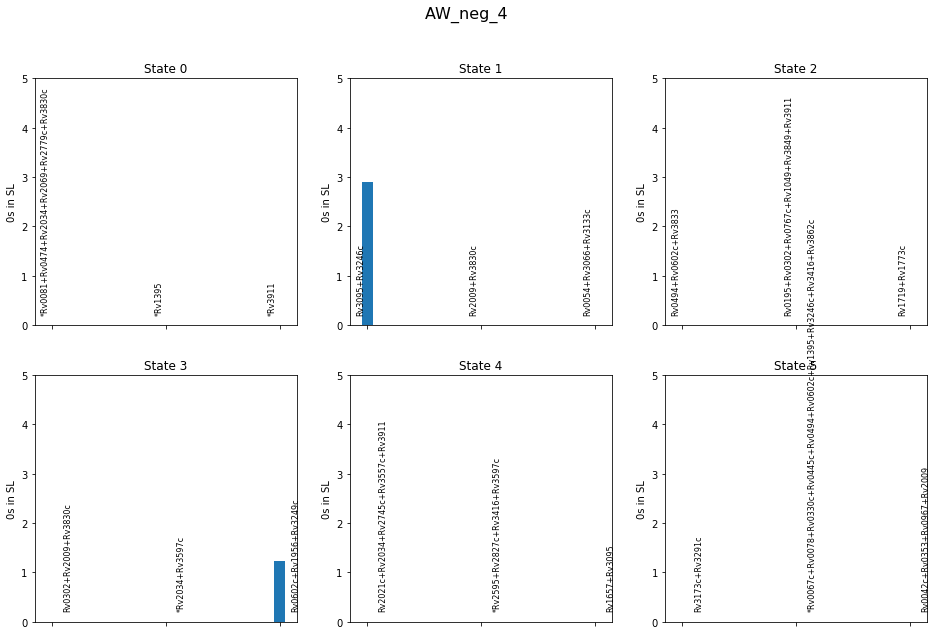

In [32]:
for instance in DF_AW.index:
    ser_X = DF_AW.loc[instance]
    fullProfile(ser_X, title=instance)

In [50]:
df.head()

,GO_Term
GENE_ID,
P9WKY5,host cell nucleus
Rv0001,DNA replication initiation---dephosphorylation...
Rv0002,extracellular region---cell wall
Rv0003,double-strand break repair---cytosol---plasma ...
Rv0005,DNA topological change---growth---magnesium io...


## Gene Analysis

In [115]:
def reportGO(genes):
    df = PROVIDER.df_go_terms.set_index(cn.GENE_ID)
    result = []
    for gene in genes:
        if gene in df.index.tolist():
            result.append('"%s: %s"\n' % (gene, df.loc[gene, "GO_Term"]))
        else:
            result.append('"%s: no description"\n' % gene)
    return result
genes = ["Rv3095", "Rv3246c", "Rv2009", "Rv3830c", "Rv0602c", "Rv1956", "Rv3249c"]
print("\n".join(reportGO(genes)))

"Rv3095: no description"

"Rv3246c: protein phosphorylation---growth of symbiont in host---positive regulation of transcriptionDNA-templated---plasma membrane"

"Rv2009: response to hypoxia---positive regulation of growth"

"Rv3830c: transcription regulatory region sequence-specific DNA binding---DNA-binding transcription factor activity---cytosol"

"Rv0602c: negative regulation of phosphorelay signal transduction system---phosphorelay response regulator activity---plasma membrane"

"Rv1956: response to hypoxia---regulation of fatty acid metabolic process---negative regulation of transcriptionDNA-templated---negative regulation of growth---positive regulation of growth---protein binding"

"Rv3249c: transcription regulatory region sequence-specific DNA binding---DNA-binding transcription factor activity---cytosol"



In [108]:
PROVIDER.df_go_terms.head()

,GENE_ID,GO_Term
0,P9WKY5,host cell nucleus
1,Rv0001,DNA replication initiation---dephosphorylation...
2,Rv0002,extracellular region---cell wall
3,Rv0003,double-strand break repair---cytosol---plasma ...
4,Rv0005,DNA topological change---growth---magnesium io...


In [119]:
ser = pd.Series(reportGO(PROVIDER.tfs))
ser.to_csv("trn_report.csv")

In [113]:
df = PROVIDER.df_go_terms.set_index(cn.GENE_ID)
df.loc["Rv0674", :]

GO_Term    growth---negative regulation of transcriptionD...
Name: Rv0674, dtype: object

In [100]:
ser.loc[1]

KeyError: 1

In [105]:
PROVIDER.tfs

['Rv0042c',
 'Rv3173c',
 'Rv0302',
 'Rv0827c',
 'Rv1395',
 'Rv2250c',
 'Rv0078',
 'Rv1219c',
 'Rv0117',
 'Rv3246c',
 'Rv2642',
 'Rv1828',
 'Rv0967',
 'Rv3164c',
 'Rv3133c',
 'Rv3183',
 'Rv3416',
 'Rv0330c',
 'Rv2359',
 'Rv1719',
 'Rv3082c',
 'Rv3676',
 'Rv2021c',
 'Rv0023',
 'Rv3124',
 'Rv3414c',
 'Rv3095',
 'Rv1189',
 'Rv1956',
 'Rv0602c',
 'Rv1846c',
 'Rv3050c',
 'Rv0653c',
 'Rv1423',
 'Rv0081',
 'Rv0324',
 'Rv3830c',
 'Rv2488c',
 'Rv2069',
 'Rv0981',
 'Rv0195',
 'Rv1404',
 'Rv3219',
 'Rv0474',
 'Rv3597c',
 'Rv0880',
 'Rv0158',
 'Rv1773c',
 'Rv3249c',
 'Rv1460',
 'Rv0494',
 'Rv3405c',
 'Rv1379',
 'Rv1556',
 'Rv1675c',
 'Rv0067c',
 'Rv1473A',
 'Rv2745c',
 'Rv0353',
 'Rv0232',
 'Rv2506',
 'Rv3291c',
 'Rv3849',
 'Rv3223c',
 'Rv0238',
 'Rv2011c',
 'Rv3911',
 'Rv3066',
 'Rv2595',
 'Rv1332',
 'Rv0047c',
 'Rv3855',
 'Rv0767c',
 'Rv2017',
 'Rv1359',
 'Rv0022c',
 'Rv2009',
 'Rv3417c',
 'Rv1186c',
 'Rv3260c',
 'Rv0623',
 'Rv3557c',
 'Rv0891c',
 'Rv3833',
 'Rv0135c',
 'Rv3862c',
 'Rv3167c',
 'R